In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from lib_for_growth_model import *
from decimal import Decimal
import numpy as np
from scipy.stats import gaussian_kde
from pandas_helper import *

In [3]:
from pandas.io import wb

In [4]:
codes = read_csv('wbccodes2014.csv')

In [5]:
ini_data = pd.read_csv("ini_data_info_may14.csv")

In [6]:
ini_data.columns

Index(['countrycode', 'wbreg', 'shareemp', 'shareag', 'sharemanu', 'poorag',
       'poorindus', 'poorserv', 'pooremp', 'poorold', 'poorunemp',
       'poorchildren', 'below125', 'pooradult', 'skillpag', 'skillpserv',
       'skillpmanu', 'gdp', 'gdppc', 'quintile2', 'quintilepc2', 'below4',
       'below6', 'below8', 'below10', 'gini', 'tot_pop', 'gap', 'incbott20',
       'inc2040', 'incbott40', 'avincome', 'shbottom20ag', 'cat7workers',
       'old', 'nonaginc', 'aginc'],
      dtype='object')

In [7]:
def correct_countrycode(countrycode):
    '''
    Corrects countrycodes in the database that don't correspond to official 3 letters codes.
    '''
    if countrycode=='TMP':
        countrycode='TLS'
    if countrycode=='ZAR':
        countrycode='COD'
    if countrycode=='ROM':
        countrycode='ROU'
    return countrycode

In [8]:
codes['country'] = codes.country.apply(correct_countrycode)

In [9]:
nameofthisround = 'sept2016_separate_impacts'

In [10]:
model = os.getcwd()
bau_folder   = "{}/baselines_{}/".format(model,nameofthisround)
cc_folder    = "{}/with_cc_{}/".format(model,nameofthisround)

In [11]:
list_bau = os.listdir(bau_folder)
list_cc  = os.listdir(cc_folder)
bau = pd.DataFrame()
cc  = pd.DataFrame()

for file in list_bau:
    bau = bau.append(pd.read_csv(bau_folder+file).drop('Unnamed: 0',axis=1))
    
for file in list_cc:
    temp = pd.read_csv(cc_folder+file).drop('Unnamed: 0',axis=1)
    if "disasters" not in file:
        print(file)
        temp = temp.ix[temp.switch_disasters==0,:]
    cc = cc.append(temp)

outputs_spark_cc_0_100.csv
outputs_spark_cc_100_200.csv
outputs_spark_cc_200_300.csv


C:\Miniconda3\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [12]:
bau = bau.drop_duplicates(['country', 'scenar', 'ssp'])
cc = cc.dropna()
bau = bau.dropna()

In [13]:
for col_switch in ['switch_ag_rev','switch_temp', 'switch_ag_prices', 'switch_disasters', 'switch_health']:
    cc.ix[cc[col_switch],"switch"] = col_switch

In [14]:
cc['issp5'] = cc.ssp=='ssp5'
bau['issp5'] = bau.ssp=='ssp5'

In [15]:
bau['countryname'] = bau.country.replace(codes.set_index('country').country_name)

In [16]:
cc['countryname'] = cc.country.replace(codes.set_index('country').country_name)

In [17]:
ini_data['countryname'] = ini_data.countrycode.replace(codes.set_index('country').country_name)

In [21]:
cc['inigdp_survey'] = cc.countryname.replace(ini_data.set_index('countryname').gdp)
cc['inigdppc_survey'] = cc.countryname.replace(ini_data.set_index('countryname').gdppc)

In [22]:
cc['ini_poor'] = cc.countryname.replace(ini_data.set_index('countryname').below125)
cc['ini_pop']  = cc.countryname.replace(ini_data.set_index('countryname').tot_pop)

In [225]:
cc['wbregion']  = cc.country.replace(codes.set_index('country').wbregion)

In [226]:
bau['wbregion']  = bau.country.replace(codes.set_index('country').wbregion)

In [118]:
graphs_folder = "country_results/"
if not os.path.exists(graphs_folder):
    os.makedirs(graphs_folder)

In [116]:
codes[codes.wbregion=='SAS'].country

2      AFG
17     BGD
29     BTN
87     IND
112    LKA
123    MDV
145    NPL
148    PAK
Name: country, dtype: object

In [227]:
bau_c_extr  = bau[bau.wbregion=="SAS"]
cc_c_extr  = cc[cc.wbregion=="SAS"]

In [228]:
hop = cc_c_extr.set_index(['country','scenar', 'ssp','ccint','switch'])
hip = broadcast_simple(bau_c_extr.set_index(['country','scenar', 'ssp']),\
                       hop.index)

In [229]:
hop['extr_poor_diff'] = (hop['below125']-hip['below125'])
hop['extr_poor_diff_pc_of_pop'] = (hop['below125']-hip['below125'])/hop['tot_pop']
hop['incbott40diff'] = (hop.incbott40-hip.incbott40)/hip.incbott40
hop['avincomediff'] = (hop.avincome-hip.avincome)/hip.avincome

In [232]:
hop.columns

Index(['year', 'switch_ag_rev', 'switch_temp', 'switch_ag_prices',
       'switch_disasters', 'switch_health', 'GDP', 'avincome', 'incbott10',
       'incbott20', 'inc2040', 'incbott40', 'quintilecum1', 'quintilecum2',
       'quintilepc1', 'quintilepc2', 'below125', 'below2', 'below4', 'below6',
       'below8', 'below10', 'gini', 'tot_pop', 'gap125', 'gap2', 'gap4',
       'gap6', 'gap8', 'gap10', 'childrenag', 'childrenonag', 'peopleag',
       'peoplenonag', 'avincomeag', 'avincomenonag', 'shareag', 'sharemanu',
       'shareemp', 'grserv', 'grag', 'grmanu', 'skillpserv', 'skillpag',
       'skillpmanu', 'p', 'b', 'voice', 'fprice_increase', 'farmer_rev_change',
       'transmission', 'food_cursor', 'temp_impact', 'paramshstunt',
       'malaria_cursor', 'diarrhea_cursor', 'disasters_cursor',
       'malaria_share', 'diarrhea_share', 'flood_share_poor',
       'flood_share_nonpoor', 'drought_share', 'wind_share', 'surge_share',
       'prod_gr_ag', 'prod_gr_serv', 'prod_gr_manu', '

In [237]:
keep = hop[['year','extr_poor_diff','extr_poor_diff_pc_of_pop','incbott40diff', 'avincomediff']].reset_index().drop(['scenar','ssp','ccint'],axis=1)

In [50]:
aa = dict({'switch_ag_rev':"Agriculture\n revenues",\
           "switch_temp":"Labor\nproductivity",\
           "switch_ag_prices":"Food prices",\
           "switch_disasters":"Disasters",\
           "switch_health":"Health"})

In [247]:
keep['switch'] = keep.switch.replace(aa)

In [249]:
save = keep[['extr_poor_diff','incbott40diff', 'avincomediff','country','switch']].groupby(['country','switch']).describe()

In [251]:
writer = pd.ExcelWriter('south_asia_results.xlsx', engine='openpyxl')
save.to_excel(writer, 'Sheet1')
writer.save()

In [204]:
sum(bau.country=='PAK')

600

In [255]:
selectedcountry = "PAK"

In [256]:
bau_c = bau[bau.country==selectedcountry]
cc_c  = cc[cc.country==selectedcountry]

In [257]:
hop = cc_c.set_index(['scenar', 'ssp','ccint','switch'])
hip = broadcast_simple(bau_c.set_index(['scenar', 'ssp']),\
                       hop.index)

In [258]:
hop['below125diff'] = (hop['below125']-hip['below125'])
hop['below125diff_pc_of_pop'] = (hop['below125']-hip['below125'])/hop['tot_pop']
hop['below125diff_relative_change'] = (hop['below125']-hip['below125'])/hip['below125']


In [259]:
hop['inc20diffpc'] = (hop.incbott20-hip.incbott20)/hip.incbott20
hop['ginidiff'] = (hop.gini-hip.gini)


In [260]:
hop['incbott40diff'] = (hop.incbott40-hip.incbott40)/hip.incbott40
hop['avincomediff'] = (hop.avincome-hip.avincome)/hip.avincome
hop['GDPpcdiff'] = (hop.GDP/hop.tot_pop-hip.GDP/hip.tot_pop)/(hip.GDP/hip.tot_pop)
hop['GDPdiff'] = (hop.GDP-hip.GDP)

In [261]:
hop['GDPbau'] = hip.GDP
hop['poorbau'] = hip.below125
hop['poorbaupc'] = hip.below125/hip.tot_pop
hop['GDPpcbau'] = hip.GDP/hip.tot_pop

In [262]:
hop['growthpc_bau'] = (hop.GDPpcbau/hop.inigdppc_survey)**(1/(2030-2007))-1
hop['growthpc_cc'] = (hop.GDP/hop.tot_pop/hop.inigdppc_survey)**(1/(2030-2007))-1

In [263]:
hop['pov_reduc_bau'] = hop.ini_poor/hop.ini_pop-hop.below125/hop.tot_pop

In [264]:
hop['diff_below10'] = (hop['below10']-hip['below10'])

In [150]:
from lib_for_plot import *
import seaborn as sns

sns.set_context("poster",rc={"font.size": 18})
sns.set_style("whitegrid")

In [151]:
import matplotlib.gridspec as gridspec

In [215]:
hop.below125diff.describe()

count       6000.000000
mean      616974.716861
std       916434.013929
min     -6719902.698886
25%        23242.108509
50%       383831.686962
75%       937523.316287
max      8951217.400002
Name: below125diff, dtype: float64

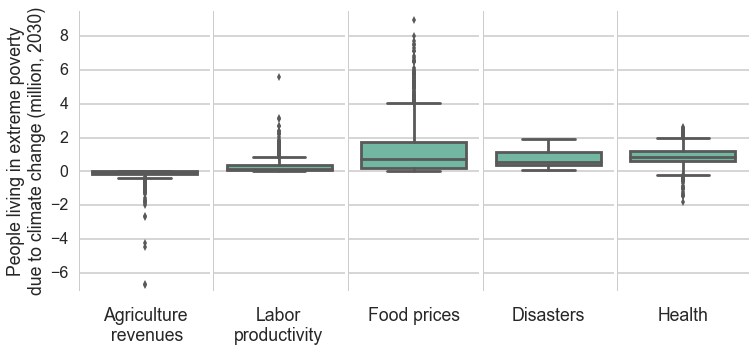

In [217]:
font = {'family' : 'sans serif',
    'size'   : 16}
plt.rc('font', **font)

titles = ["Agriculture\n revenues","Labor\nproductivity","Food prices","Disasters","Health"]

fig = plt.figure(figsize=(12,5))
gs1 = gridspec.GridSpec(1, 5)
gs1.update(wspace=0.025, hspace=0.05)
i=0

for switch in ['switch_ag_rev','switch_temp', 'switch_ag_prices', 'switch_disasters', 'switch_health']:
    ax = fig.add_subplot(gs1[i])
    ax.get_xaxis().set_ticks([])
    ax.set_ylim([-7,9.5])
    spine_and_ticks(ax)
    #ax.set_aspect('equal')

    to_plot = pd.DataFrame(hop.below125diff.unstack("switch")[switch].reset_index())
    to_plot["ccint"] = to_plot["ccint"].replace(dict({0:'Low',1:'High'}))
    to_plot[switch] = 10**(-6)*to_plot[switch]

    to_plot['prout']=""

    sns.boxplot(x='prout',y=switch,data=to_plot,ax=ax,palette="Set2")
    plt.xlabel(titles[i])
    sns.despine(bottom=True)
    if i==0:
        plt.ylabel("People living in extreme poverty\ndue to climate change (million, 2030)")
    else:
        plt.ylabel("")
        ax.set_yticklabels([])
    i+=1
    
plt.savefig("{}all_impacts_extrpoors_{}".format(graphs_folder,selectedcountry),bbox_inches="tight",dpi=200)

In [218]:
hop.incbott40diff.describe()

count    6000.000000
mean       -0.012672
std         0.014497
min        -0.079048
25%        -0.019301
50%        -0.008676
75%        -0.003324
max         0.015180
Name: incbott40diff, dtype: float64

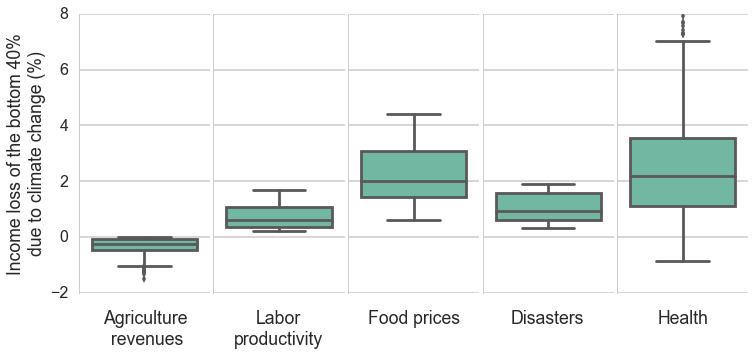

In [219]:
font = {'family' : 'sans serif',
    'size'   : 16}
plt.rc('font', **font)

titles = ["Agriculture\n revenues","Labor\nproductivity","Food prices","Disasters","Health"]

fig = plt.figure(figsize=(12,5))
gs1 = gridspec.GridSpec(1, 5)
gs1.update(wspace=0.025, hspace=0.05)
i=0

for switch in ['switch_ag_rev','switch_temp', 'switch_ag_prices', 'switch_disasters', 'switch_health']:
    ax = fig.add_subplot(gs1[i])
    ax.get_xaxis().set_ticks([])
    ax.set_ylim([-2,8])
    spine_and_ticks(ax)
    #ax.set_aspect('equal')

    to_plot = pd.DataFrame(hop.incbott40diff.unstack("switch")[switch].reset_index())
    to_plot["ccint"] = to_plot["ccint"].replace(dict({0:'Low',1:'High'}))
    to_plot[switch] = -100*to_plot[switch]

    to_plot['prout']=""

    sns.boxplot(x='prout',y=switch,data=to_plot,ax=ax,palette="Set2")
    plt.xlabel(titles[i])
    sns.despine(bottom=True)
    if i==0:
        plt.ylabel("Income loss of the bottom 40%\ndue to climate change (%)")
    else:
        plt.ylabel("")
        ax.set_yticklabels([])
    i+=1
    
plt.savefig("{}all_impacts_bott40_{}".format(graphs_folder,selectedcountry),bbox_inches="tight",dpi=200)

In [38]:
from lib_for_analysis import *

In [39]:
def anova_table(varin,data,experiments_cols):
    formula = varin+" ~ " + "+".join(experiments_cols)
    olsmodel=ols(formula,data=data).fit()
    table=anova_lm(olsmodel)
    table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()
    table=table.sort(['sum_sq'],ascending=False)
    return table['sum_sq_pc']

In [40]:
myinputs = ['shareag','sharemanu', 'shareemp', 'grserv', 'grag', 'grmanu', 'skillpserv',\
       'skillpag', 'skillpmanu', 'p', 'b','ccint','issp5','voice']

In [41]:
def drivers_matrix(var,hop,myinputs):
    impacts=['switch_ag_rev','switch_temp', 'switch_ag_prices', 'switch_disasters', 'switch_health']
    df = pd.DataFrame(index=impacts,columns=myinputs+["Residual"])
    for switch in impacts:
        to_plot = hop[hop[switch]].reset_index()
        to_plot["ccint"] = to_plot["ccint"].replace(dict({0:'Low',1:'High'}))
        t = anova_table(var,to_plot,myinputs)
        df.loc[switch,:]=t
    return df

In [220]:
drivers_country_poor_pc = drivers_matrix('below125diff_pc_of_pop',hop,myinputs)
drivers_country_incbott40 = drivers_matrix('incbott40diff',hop,myinputs)

In [252]:
drivers_country_poor_pc

,shareag,sharemanu,shareemp,grserv,grag,grmanu,skillpserv,skillpag,skillpmanu,p,b,ccint,issp5,voice,Residual
switch_ag_rev,0.0265033,0.004199818,0.003865194,0.006868562,0.04469906,0.003061268,0.004609529,0.0001212005,0.002993872,1.547275e-06,0.01059803,0.01590082,0.05415973,0.0004643148,0.8219537
switch_temp,0.009909392,0.001034647,0.0002171383,0.02684164,0.06484894,0.01572987,0.006375583,9.39783e-05,0.0002794989,0.001304879,0.02004974,0.1520148,0.1371775,5.537438e-05,0.564067
switch_ag_prices,0.006010718,0.005615084,0.007754189,0.05353438,0.04173658,0.0189947,0.0189898,0.0004086737,0.001620021,0.001313306,0.01030282,0.1447068,0.3871173,3.192167e-06,0.3018924
switch_disasters,0.004318182,0.008512793,0.01428092,0.05577714,0.009561849,0.01028824,0.04445477,0.001148258,0.002872009,9.059904e-05,4.655719e-05,0.6052582,0.1093213,2.685969e-05,0.1340423
switch_health,0.0003140163,0.03373245,0.02842942,0.1490756,0.102053,0.1173262,0.05532553,0.002689393,0.007215592,1.479852e-06,0.1248371,0.04294733,0.04085179,0.04104413,0.2541569


In [48]:
bb = dict({'shareag':'Share of workers in ag',\
                    'sharemanu':'Share of workers in manu',\
                    'shareemp':'Employment rate',\
                    'grserv':'Growth in services',\
                    'grag':'Growth in ag',\
                    'grmanu':'Growth in manu',\
                    'skillpserv':'Skill premium services',\
                    'skillpag':'Skill premium ag',\
                    'skillpmanu':'Skill premium manu',\
                    'p':'Pensions',\
                    'b':'Redistribution',\
                    'ccint':'Climate change impacts',\
                    'issp5':'Demographics',\
                    'voice':'Governance'  })

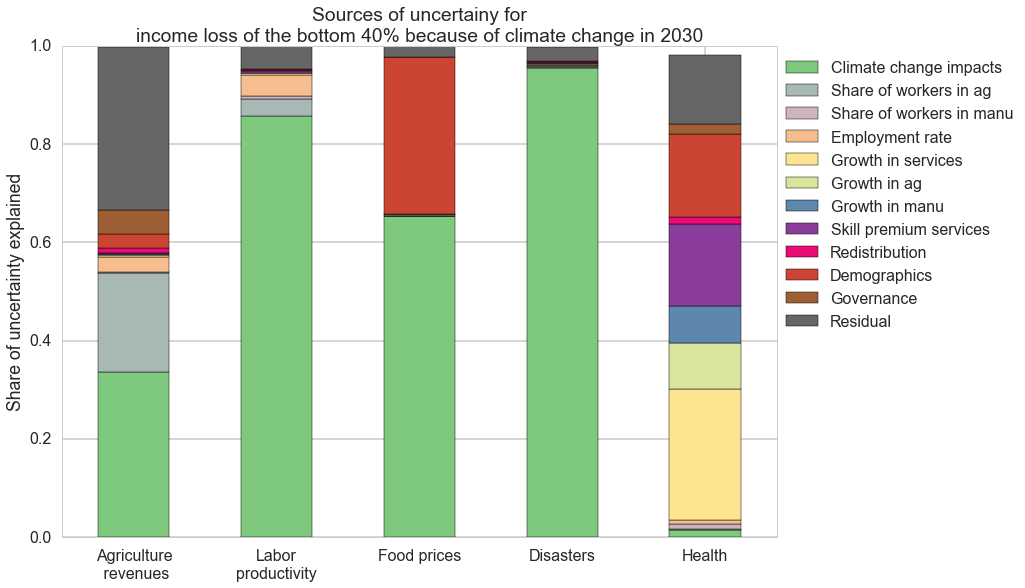

In [221]:
to_plot = drivers_country_incbott40.rename(columns=bb).rename(index=aa)
cci = to_plot['Climate change impacts']
to_plot.drop(labels=['Climate change impacts'], axis=1,inplace = True)
to_plot.insert(0, 'Climate change impacts', cci)
ax=to_plot.drop([col for col, val in to_plot.sum(axis=0).iteritems() if val < 0.02], axis=1).plot(kind='bar',stacked=True,rot=0,colormap="Accent")
ax.legend(bbox_to_anchor=(1.35, 1.))
plt.title("Sources of uncertainy for\nincome loss of the bottom 40% because of climate change in 2030")
plt.ylabel("Share of uncertainty explained")
plt.savefig("{}uncertainty_bott40_{}".format(graphs_folder,selectedcountry),bbox_inches="tight",dpi=200)

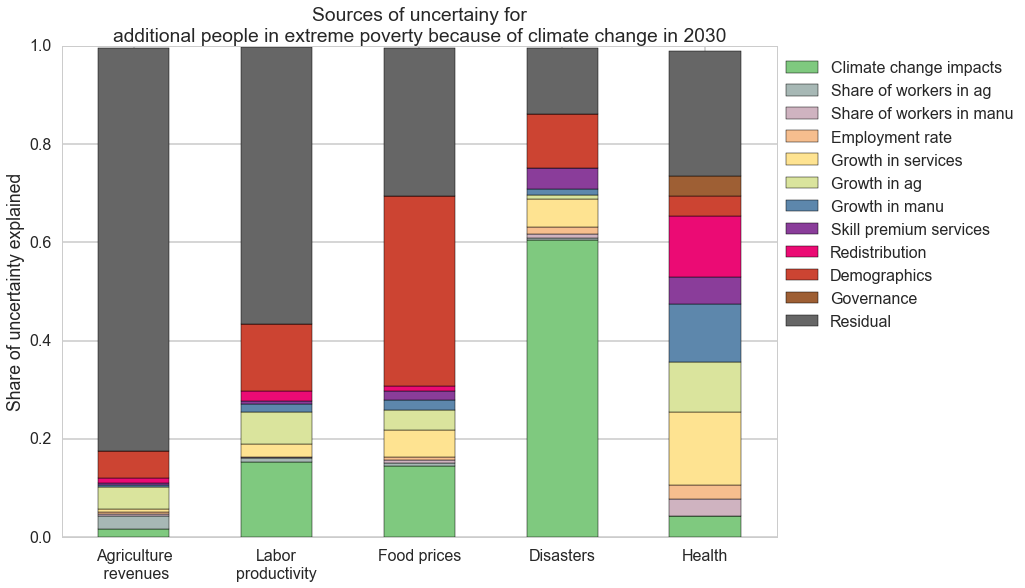

In [222]:
to_plot = drivers_country_poor_pc.rename(columns=bb).rename(index=aa)
cci = to_plot['Climate change impacts']
to_plot.drop(labels=['Climate change impacts'], axis=1,inplace = True)
to_plot.insert(0, 'Climate change impacts', cci)
ax=to_plot.drop([col for col, val in to_plot.sum(axis=0).iteritems() if val < 0.02], axis=1).plot(kind='bar',stacked=True,rot=0,colormap="Accent")
ax.legend(bbox_to_anchor=(1.35, 1.))
plt.title("Sources of uncertainy for\nadditional people in extreme poverty because of climate change in 2030")
plt.ylabel("Share of uncertainty explained")
plt.savefig("{}uncertainty_extrpoor_{}".format(graphs_folder,selectedcountry),bbox_inches="tight",dpi=200)

In [274]:
from sklearn import tree
from IPython.display import Image  
from sklearn.datasets import load_iris
import pydotplus 

In [310]:
impacts=['switch_ag_rev','switch_temp', 'switch_ag_prices', 'switch_disasters', 'switch_health']
for switch in ['switch_health']:
    to_plot = hop[hop[switch]].reset_index()
    x = to_plot[myinputs]
    y = to_plot.incbott40diff
    header = myinputs
    experiments = x
    mass_min = 0.05
    clf = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=int(mass_min*x.shape[0]))
    clf = clf.fit(x,y)
    clf = clf.fit(x,y)
    list_boxes,threevar,threesign,threevalues=get_lineage(clf, header)

In [311]:
list_boxes

["(experiments['shareemp']<=0.579790830612)&(experiments['grmanu']<=-0.0131122842431)&(experiments['skillpmanu']<=3.44851446152)",
 "(experiments['shareemp']<=0.579790830612)&(experiments['grmanu']<=-0.0131122842431)&(experiments['skillpmanu']>=3.44851446152)",
 "(experiments['shareemp']<=0.579790830612)&(experiments['grmanu']>=-0.0131122842431)&(experiments['shareag']<=0.323100030422)",
 "(experiments['shareemp']<=0.579790830612)&(experiments['grmanu']>=-0.0131122842431)&(experiments['shareag']>=0.323100030422)",
 "(experiments['shareemp']>=0.579790830612)&(experiments['b']<=0.133177235723)&(experiments['b']<=0.0742199346423)",
 "(experiments['shareemp']>=0.579790830612)&(experiments['b']<=0.133177235723)&(experiments['b']>=0.0742199346423)",
 "(experiments['shareemp']>=0.579790830612)&(experiments['b']>=0.133177235723)&(experiments['grmanu']<=0.000557286606636)",
 "(experiments['shareemp']>=0.579790830612)&(experiments['b']>=0.133177235723)&(experiments['grmanu']>=0.000557286606636)"

In [312]:
threevar

[['shareemp', 'grmanu', 'skillpmanu'],
 ['shareemp', 'grmanu', 'skillpmanu'],
 ['shareemp', 'grmanu', 'shareag'],
 ['shareemp', 'grmanu', 'shareag'],
 ['shareemp', 'b', 'b'],
 ['shareemp', 'b', 'b'],
 ['shareemp', 'b', 'grmanu'],
 ['shareemp', 'b', 'grmanu']]